# Logistic regression

## Introduction

Let $Y$ be a **dependent variable**, also called **response variable** or **predictor**, whose behaviour can be explained by the **independent variables** $X_1, X_2, \ldots, X_k$, also known as **explanatory variables** or **features**.

In classification, $Y$ is a binary variable belonging to either one of two classes, labeled as 0 or 1, although generalizations where $Y$ takes any (finite) number of outcomes exists.

Let $p = P(Y = 1)$, be the probability of $Y$ to belong to class 1. In logistic regression, the probability $p$ can be described as follows:
$$p = \frac{1}{1 + \exp(-(\beta_0 + \beta_1 X_1 + \ldots + \beta_k X_k))}$$
where $\beta_0, \beta_1, \ldots, \beta_k$ are the model parameters and $\exp$ denotes the exponential function. The **log odds** of the dependent variable are defined as
$$\log\frac{p}{1 - p} = \beta_0 + \beta_1 X_1 + \ldots + \beta_k X_k$$

## The logistic function

The function
$$\sigma(t) = \frac{1}{1 + e^{-t}}$$
is known as the **logistic function** (and thus the name of logistic regression), and its inverse
$$\sigma^{-1}(p) = \log\frac{p}{1 - p}, \ 0 < p < 1$$
is known as the **logit function**.

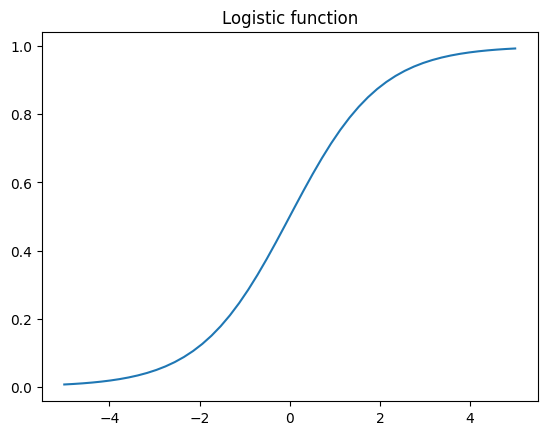

In [7]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(-5, 5)
logistic = 1/(1 + np.exp(-t))

plt.figure()
plt.title("Logistic function")
plt.plot(t, logistic, "-")
plt.show()

/tmp/ipykernel_13948/4067377933.py:2: RuntimeWarning: divide by zero encountered in divide
  logit = np.log(p/(1 - p))
/tmp/ipykernel_13948/4067377933.py:2: RuntimeWarning: divide by zero encountered in log
  logit = np.log(p/(1 - p))


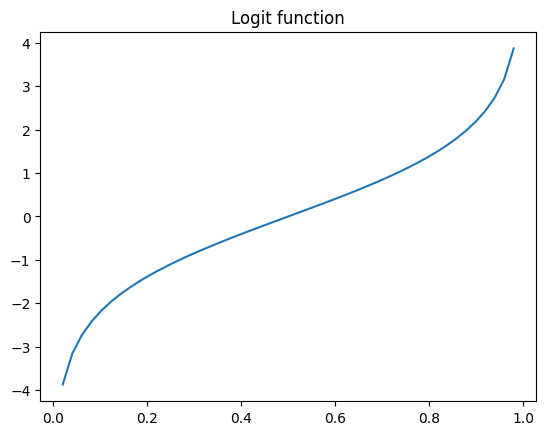

In [11]:
p = np.linspace(0, 1)
logit = np.log(p/(1 - p))

plt.figure()
plt.title("Logit function")
plt.plot(p, logit, "-")
plt.show()

## Estimation

Let
* $\mathbf{y} = (y_1, \ldots, y_n)$ be the vector of observed dependent variables,
* $\mathbf{\beta} = (\beta_0, \beta_1, \ldots, \beta_k)$ be the vector of model parameters, and
* $\mathbf{X} = (x_{ij})$ be the matrix of observed independent variables, where each row $\mathbf{x}_i = (1, x_{i1}, \ldots, x_{ik})$ represents an observation and each column represents a feature. The first column of $\mathbf{X}$ is filled with ones and is the column corresponding to the intercept $\beta_0$.

Additionally, let
* $\mathbf{\mu}$ denote the vector whose $i$-th entry is $p = \frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}$, and
* $W$ denote the diagonal matrix whose $i$-th diagonal entry is $p(1 - p) = \left(\frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)\left(1 - \frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)$. 

The model parameters $\mathbf{\beta}$ can be estimated by applying the following iterative method:
1. Begin with an initial guess $\mathbf{\beta}^{(0)}$.
2. At each iteration, update the parameters using the following rule:
$$\mathbf{\beta}^{(t + 1)} = \mathbf{\beta}^{(t)} + (\mathbf{X}^{\top}\mathbf{WX})^{-1} \mathbf{X}^{\top}(\mathbf{y} - \mathbf{\mu})$$

The method ends once the parameters stop changing, i.e. when $\mathbf{\beta}^{(t + 1)}$ is virtually the same as $\mathbf{\beta}^{(t)}$, or when a maximum number of iterations have been reached.

See [Maximum likelihood estimator](#maximum-likelihood-estimator) for the deduction of this method.

## Maximum likelihood estimator

Let $(\mathbf{x}_i, y_i)$, $i = 1, 2, \ldots, n$ be observations of the independent and dependent variables. Recall that $y_i$ follows a Bernoulli distribution with probability of success $p = 1/(1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta}))$. The likelihood function of the dependent variables, which is defined as the joint density function as a function of the parameters, is
\begin{align*}
L(\mathbf{\beta} | \mathbf{X}, \mathbf{y}) &= \prod_{i=1}^{n} p^{y_i}(1 - p)^{1 - y_i} \\
&= \prod_{i=1}^{n} \left(\frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)^{y_i} \left(\frac{\exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)^{1 - y_i} \\
&= \prod_{i=1}^{n} \frac{\exp(-(1 - y_i)\mathbf{x}_i^{\top}\mathbf{\beta})}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}
\end{align*}

The log likelihood function is therefore
\begin{align*}
l(\mathbf{\beta} | \mathbf{X}, \mathbf{y}) &= \log L(\beta | \mathbf{X}, \mathbf{y}) \\
&= -\sum_{i=1}^{n}(1 - y_i)\mathbf{x}_i^{\top}\mathbf{\beta} - \sum_{i=1}^{n}\log(1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta}))
\end{align*}

The derivative of the log likelihood with respect to $\beta_j$ is
\begin{align*}
\frac{\partial}{\partial\beta_j} l(\beta | \mathbf{X}, \mathbf{y}) &= -\sum_{i=1}^{n}(1 - y_i)x_{ij} - \sum_{i=1}^{n}\frac{-x_{ij}\exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})} \\
&= \sum_{i=1}^{n}(y_i - 1)x_{ij} + \sum_{i=1}^{n}\left(1 - \frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)x_{ij} \\
&= \sum_{i=1}^{n}x_{ij}\left(y_i - \frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)
\end{align*}

The gradient of the log likelihood is thus
$$\nabla l(\mathbf{\beta} | \mathbf{X}, \mathbf{y}) = \mathbf{X}^{\top}(\mathbf{y} - \mathbf{\mu})$$

On the other hand, the second derivative of the log likelihood with respect to $\beta_j$ and $\beta_k$ is
\begin{align*}
\frac{\partial^2}{\partial\beta_k\partial\beta_j} l(\beta | \mathbf{X}, \mathbf{y}) &= -\sum_{i=1}^{n} \frac{x_{ij}x_{ik}\exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}{(1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta}))^2} \\
&= -\sum_{i=1}^{n} x_{ij}\left(\frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)\left(1 - \frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)x_{ik}
\end{align*}

The Hessian matrix of the log likelihood is thus
$$H_l (\mathbf{\beta} | \mathbf{X}, \mathbf{y}) = -\mathbf{X}^{\top}\mathbf{WX}$$

The equation $\nabla l(\beta | \mathbf{X}, \mathbf{y}) = \mathbf{0}$ doesn't have a closed solution, so an iterative method has to be used. By applying the Newton's method on the log likelihood we get the following iterative rule
\begin{align*}
\mathbf{\beta}^{(t + 1)} &= \mathbf{\beta}^{(t)} - H_l (\mathbf{\beta} | \mathbf{X}, \mathbf{y})^{-1} \nabla l(\mathbf{\beta} | \mathbf{X}, \mathbf{y}) \\
&= \mathbf{\beta}^{(t)} + (\mathbf{X}^{\top}\mathbf{WX})^{-1} \mathbf{X}^{\top}(\mathbf{y} - \mathbf{\mu}) 
\end{align*}